In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# loading dataset
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Project/CommentToxicity-main/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv')

In [ ]:
# shape of dataset
df.shape

(159571, 8)

In [ ]:
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Preprocessing

- Separate the comments and Labels i.e. target variable
- Vectorize the text using Tensorflow
- Preprocess the dataset
- Split the dataset into train, test and validation set

In [ ]:
# Separating predictor and target variable
X = df['comment_text']
y = df.iloc[:,2:].values

In [ ]:
from tensorflow.keras.layers import TextVectorization # for mapping text features to interger sequence

In [ ]:
# maximum number of words in the vocabulary 
max_words = 200000

In [ ]:
vectorizer = TextVectorization(max_tokens=max_words,output_mode='int', output_sequence_length=1800)
# max token: maximum vocabulary size of 200000 tokens
# output sequence: 1800, Each input text will be converted to vector of size 1800. Trucating sentences to max length 1800. If they are shorter padding them with zeores.

In [ ]:
# fitting vectorizer to text data
vectorizer.adapt(X.values)

In [ ]:
# converting text to array of size 1800
vectorized_text = vectorizer(X.values)

In [ ]:
vectorizer('Hey there brother')

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([ 425,   41, 1963, ...,    0,    0,    0])>

In [ ]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [ ]:

dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y)) # creating a dataset of tensor pairs (X and y)
dataset = dataset.cache() # stores dataset in memory for fast performance
dataset = dataset.shuffle(160000) # shuffles the dataset
dataset = dataset.batch(16) # creating batch of 16
dataset = dataset.prefetch(8) # prefetches the data for the next batch while the current batch is being processed

In [ ]:
# splitting data in 3 sets
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

# Creating Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(max_words+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh'))) 
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer - 6, because we have a vector of size that represents the toxicity indicators
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 911s 128ms/step - loss: 0.0641 - val_loss: 0.0470
Epoch 2/10
6981/6981 [==============================] - 700s 100ms/step - loss: 0.0464 - val_loss: 0.0401
Epoch 3/10
6981/6981 [==============================] - 644s 92ms/step - loss: 0.0412 - val_loss: 0.0363
Epoch 4/10
6981/6981 [==============================] - 625s 90ms/step - loss: 0.0364 - val_loss: 0.0324
Epoch 5/10
6981/6981 [==============================] - 624s 89ms/step - loss: 0.0328 - val_loss: 0.0289
Epoch 6/10
6981/6981 [==============================] - 623s 89ms/step - loss: 0.0293 - val_loss: 0.0257
Epoch 7/10
6981/6981 [==============================] - 648s 93ms/step - loss: 0.0264 - val_loss: 0.0212
Epoch 8/10
6981/6981 [==============================] - 639s 92ms/step - loss: 0.0238 - val_loss: 0.0199
Epoch 9/10
6981/6981 [==============================] - 646s 92ms/step - loss: 0.0209 - val_loss: 0.0183
Epoch 10/10
6981/6981 [==============================

<Figure size 800x500 with 0 Axes>

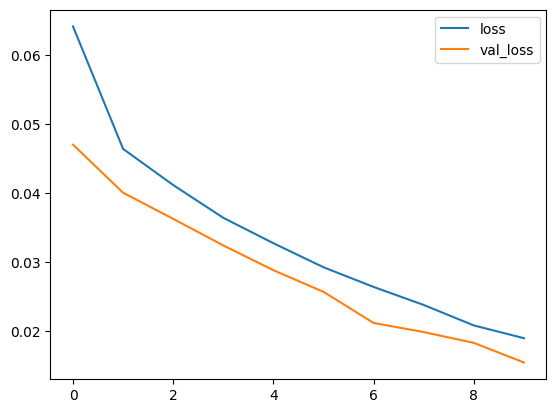

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Prediction

In [ ]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
# checking the prediction
input_text = vectorizer("I hate you. You suck")

res = model.predict(np.expand_dims(input_text,0))

(res > 0.5).astype(int)

1/1 [==============================] - 0s 56ms/step


array([[1, 0, 1, 0, 1, 0]])

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 60ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0]])

In [ ]:
res.shape

(1, 6)

# Model Evaluation

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 12.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Instantiation of metric objects
pre = Precision()
rec = Recall()
acc = CategoricalAccuracy()
acc_cross =  CategoricalCrossentropy()
f1_score = tfa.metrics.F1Score(num_classes=6,average='macro', threshold=0.5)

In [ ]:
for batch in test.as_numpy_iterator():
  # unpacking the batch 
  X_test, y_test = batch
  # predictions
  y_pred = model.predict(X_test)

  # flatten the prediction
  y_pred = y_pred.flatten()
  y_test = y_test.flatten()

  pre.update_state(y_test,y_pred)
  rec.update_state(y_test,y_pred)
  acc.update_state(y_test,y_pred)

1/1 [==============================] - 0s 53ms/step


In [ ]:
print(f'Precision:{pre.result().numpy()}\nRecall: {rec.result().numpy()}\nAccuracy:{acc.result().numpy()}')

Precision:0.9244593977928162
Recall: 0.927585244178772
Accuracy:0.454363077878952


Strange. We have got a very high Precision and Recall. But accuracy 0.45 is very low. Lets check F1 score.

In [ ]:
for batch in test.as_numpy_iterator():
  # unpacking the batch 
  X_test, y_test = batch
  # predictions
  y_pred = model.predict(X_test)

  f1_score.update_state(y_test,y_pred)

1/1 [==============================] - 0s 52ms/step


In [ ]:
print(f'F1_Score:{f1_score.result().numpy()}')

F1_Score:0.782629668712616


F1 score of 0.78 looks good. Lets proceed

# Test and Gradio

In [ ]:
! pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 

In [ ]:
import tensorflow as tf
import gradio as gr 

In [ ]:
# saving the final model
model.save('comment_toxicity_indicator.h5')

In [ ]:
model = tf.keras.models.load_model('comment_toxicity_indicator.h5')

In [ ]:
# checking predictions
input_str = vectorizer('Hey you are a big poo poo face and smell like a frog')

In [ ]:
result = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 0s 51ms/step


In [ ]:
(result>0.5).astype('int')

array([[1, 0, 0, 0, 1, 0]])

In [ ]:
# function to indicate toxicity of a particular comment
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [ ]:
print(score_comment("I will kill you that's how much I hate you."))

1/1 [==============================] - 0s 113ms/step
toxic: True
severe_toxic: False
obscene: False
threat: True
insult: False
identity_hate: False



In [ ]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [ ]:
  interface.launch(share=False)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>